In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import matplotlib as mpl

In [17]:
# Direktori input dan output
input_directory = "../raw_data/"
output_directory = "../formatted_data/"

# Membuat folder output jika belum ada
os.makedirs(output_directory, exist_ok=True)

# Loop melalui semua file di direktori input
for filename in os.listdir(input_directory):
    if filename.endswith(".csv"):
        # Path lengkap file input dan output
        input_file_path = os.path.join(input_directory, filename)
        output_file_path = os.path.join(output_directory, filename)

        # Baca file CSV
        with open(input_file_path, "r") as file:
            data = file.read()
        
        # Ganti koma dengan titik
        data = data.replace(",", ".")
        
        # Simpan kembali data yang diformat ke folder output
        with open(output_file_path, "w") as file:
            file.write(data)
        
        # Baca file CSV yang telah diformat untuk verifikasi
        df = pd.read_csv(output_file_path)
        print(f"Processed file: {filename}")
        print(df)


Processed file: 1.0 7.0 1.csv
    Time t / s;Voltage U_A1 / V;Voltage U_B1 / V;Collector current I_A / nA;Acceleration voltage U_B / V
0                              0;8.64;7.895;8.64;78.95                                                  
1                           0.1;-0.075;0.03;-0.075;0.3                                                  
2                         0.201;0.195;0.055;0.195;0.55                                                  
3                           0.299;0.27;0.085;0.27;0.85                                                  
4                           0.4;0.315;0.115;0.315;1.15                                                  
..                                                 ...                                                  
395                       39.5;0.915;7.905;0.915;79.05                                                  
396                           39.6;0.9;7.905;0.9;79.05                                                  
397                      

In [18]:
# Input and output directories
input_directory = "../formatted_data"
output_directory = "../cleaned_data"

# Create a folder for cleaned data
os.makedirs(output_directory, exist_ok=True)

# Z-score calculation function for rolling windows
def zscore(series, window, threshold=3, return_all=False):
    # Calculate rolling mean and std
    avg = series.rolling(window=window, center=True).mean()
    std = series.rolling(window=window, center=True).std()
    
    # Z-score calculation
    z = (series - avg) / std
    
    # Identify outliers: absolute z-score greater than threshold
    mask = np.abs(z) <= threshold  # Boolean mask for non-outliers
    
    if return_all:
        return z, avg, std, mask
    return mask

# Function to clean data using rolling z-score
def clean_data_with_rolling_zscore(df, x_col, y_col, window, threshold):
    # Ensure the columns are numeric
    df[x_col] = pd.to_numeric(df[x_col], errors='coerce')
    df[y_col] = pd.to_numeric(df[y_col], errors='coerce')
    
    # Drop NaN values
    df = df.dropna(subset=[x_col, y_col])
    
    # Apply rolling z-score method to the y_col
    mask = zscore(df[y_col], window=window, threshold=threshold)
    
    # Filter the data using the mask
    filtered_df = df[mask]
    return filtered_df

# Process each file in the folder
for file_name in os.listdir(input_directory):
    if file_name.endswith(".csv"):
        file_path = os.path.join(input_directory, file_name)

        # Read the CSV file with the correct delimiter
        df = pd.read_csv(file_path, delimiter=';')

        # Clean the data with rolling z-score
        cleaned_df = clean_data_with_rolling_zscore(
            df, 
            x_col='Acceleration voltage U_B / V', 
            y_col='Collector current I_A / nA', 
            window=50, 
            threshold=3
        )
        
        # Save the cleaned data
        cleaned_file_path = os.path.join(output_directory, file_name)
        cleaned_df.to_csv(cleaned_file_path, index=False)

        # Read all cleaned CSV data for verification
        df = pd.read_csv(cleaned_file_path)
        print(f"Processed file: {file_name}")
        print(df)

print("Data cleaning completed. Cleaned files are saved in the 'cleaned_data' folder.")


Processed file: 1.0 7.0 1.csv
     Time t / s  Voltage U_A1 / V  Voltage U_B1 / V  \
0         2.501             0.510             0.720   
1         2.600             0.510             0.750   
2         2.700             0.525             0.780   
3         2.800             0.525             0.805   
4         2.901             0.525             0.835   
..          ...               ...               ...   
346      37.100             1.065             7.905   
347      37.200             1.065             7.905   
348      37.301             1.050             7.905   
349      37.400             1.035             7.905   
350      37.500             1.035             7.905   

     Collector current I_A / nA  Acceleration voltage U_B / V  
0                         0.510                          7.20  
1                         0.510                          7.50  
2                         0.525                          7.80  
3                         0.525                      

In [19]:
# Path ke folder data CSV
folder_path = '../cleaned_data/'  # Ganti dengan path folder yang benar
csv_files = ["1.5 7.0 1.csv", "1.5 7.0 2.csv", "1.5 7.0 3.csv",
             "1.0 7.0 1.csv", "1.0 7.0 2.csv", "1.0 7.0 3.csv",
             "2.0 7.0 1.csv", "2.0 7.0 2.csv", "2.0 7.0 3.csv",
             "1.5 6.0 1.csv", "1.5 6.0 2.csv", "1.5 6.0 3.csv",
             "1.5 8.0 1.csv", "1.5 8.0 2.csv", "1.5 8.0 3.csv"]
separator = ","

In [20]:
# function to remove value x in list "data"
def remove_value(data, x):
    return [value for value in data if value != x]

# function to find average of flat peak
def avg_peak(x, y, peak):
    flat_peak = [x[peak]]
    
    #check backward
    i=1
    while(y[peak-i] == y[peak]):
        flat_peak.append(x[peak-i])
        i+=1
    
    #check forward
    i=1
    while(y[peak+i] == y[peak]):
        flat_peak.append(x[peak+i])
        i+=1
    
    return sum(flat_peak)/len(flat_peak)

# adjust ylim for all
def adjust_ylim(variasi_ke, lim_var_1 = None, lim_var_2 = None, lim_var_3 = None, lim_var_4 = None, lim_var_5 = None, ax=None):
    if(ax==None):
        if(variasi_ke == 1 and lim_var_1 != None):
            plt.ylim(lim_var_1)
        elif(variasi_ke == 2 and lim_var_2 != None):
            plt.ylim(lim_var_2)
        elif(variasi_ke == 3 and lim_var_3 != None):
            plt.ylim(lim_var_3)
        elif(variasi_ke == 4 and lim_var_4 != None):
            plt.ylim(lim_var_4)
        elif(variasi_ke == 5 and lim_var_5 != None):
            plt.ylim(lim_var_5)
    else:
        if(variasi_ke == 1 and lim_var_1 != None):
            ax.set_ylim(lim_var_1)
        elif(variasi_ke == 2 and lim_var_2 != None):
            ax.set_ylim(lim_var_2)
        elif(variasi_ke == 3 and lim_var_3 != None):
            ax.set_ylim(lim_var_3)
        elif(variasi_ke == 4 and lim_var_4 != None):
            ax.set_ylim(lim_var_4)
        elif(variasi_ke == 5 and lim_var_5 != None):
            ax.set_ylim(lim_var_5)

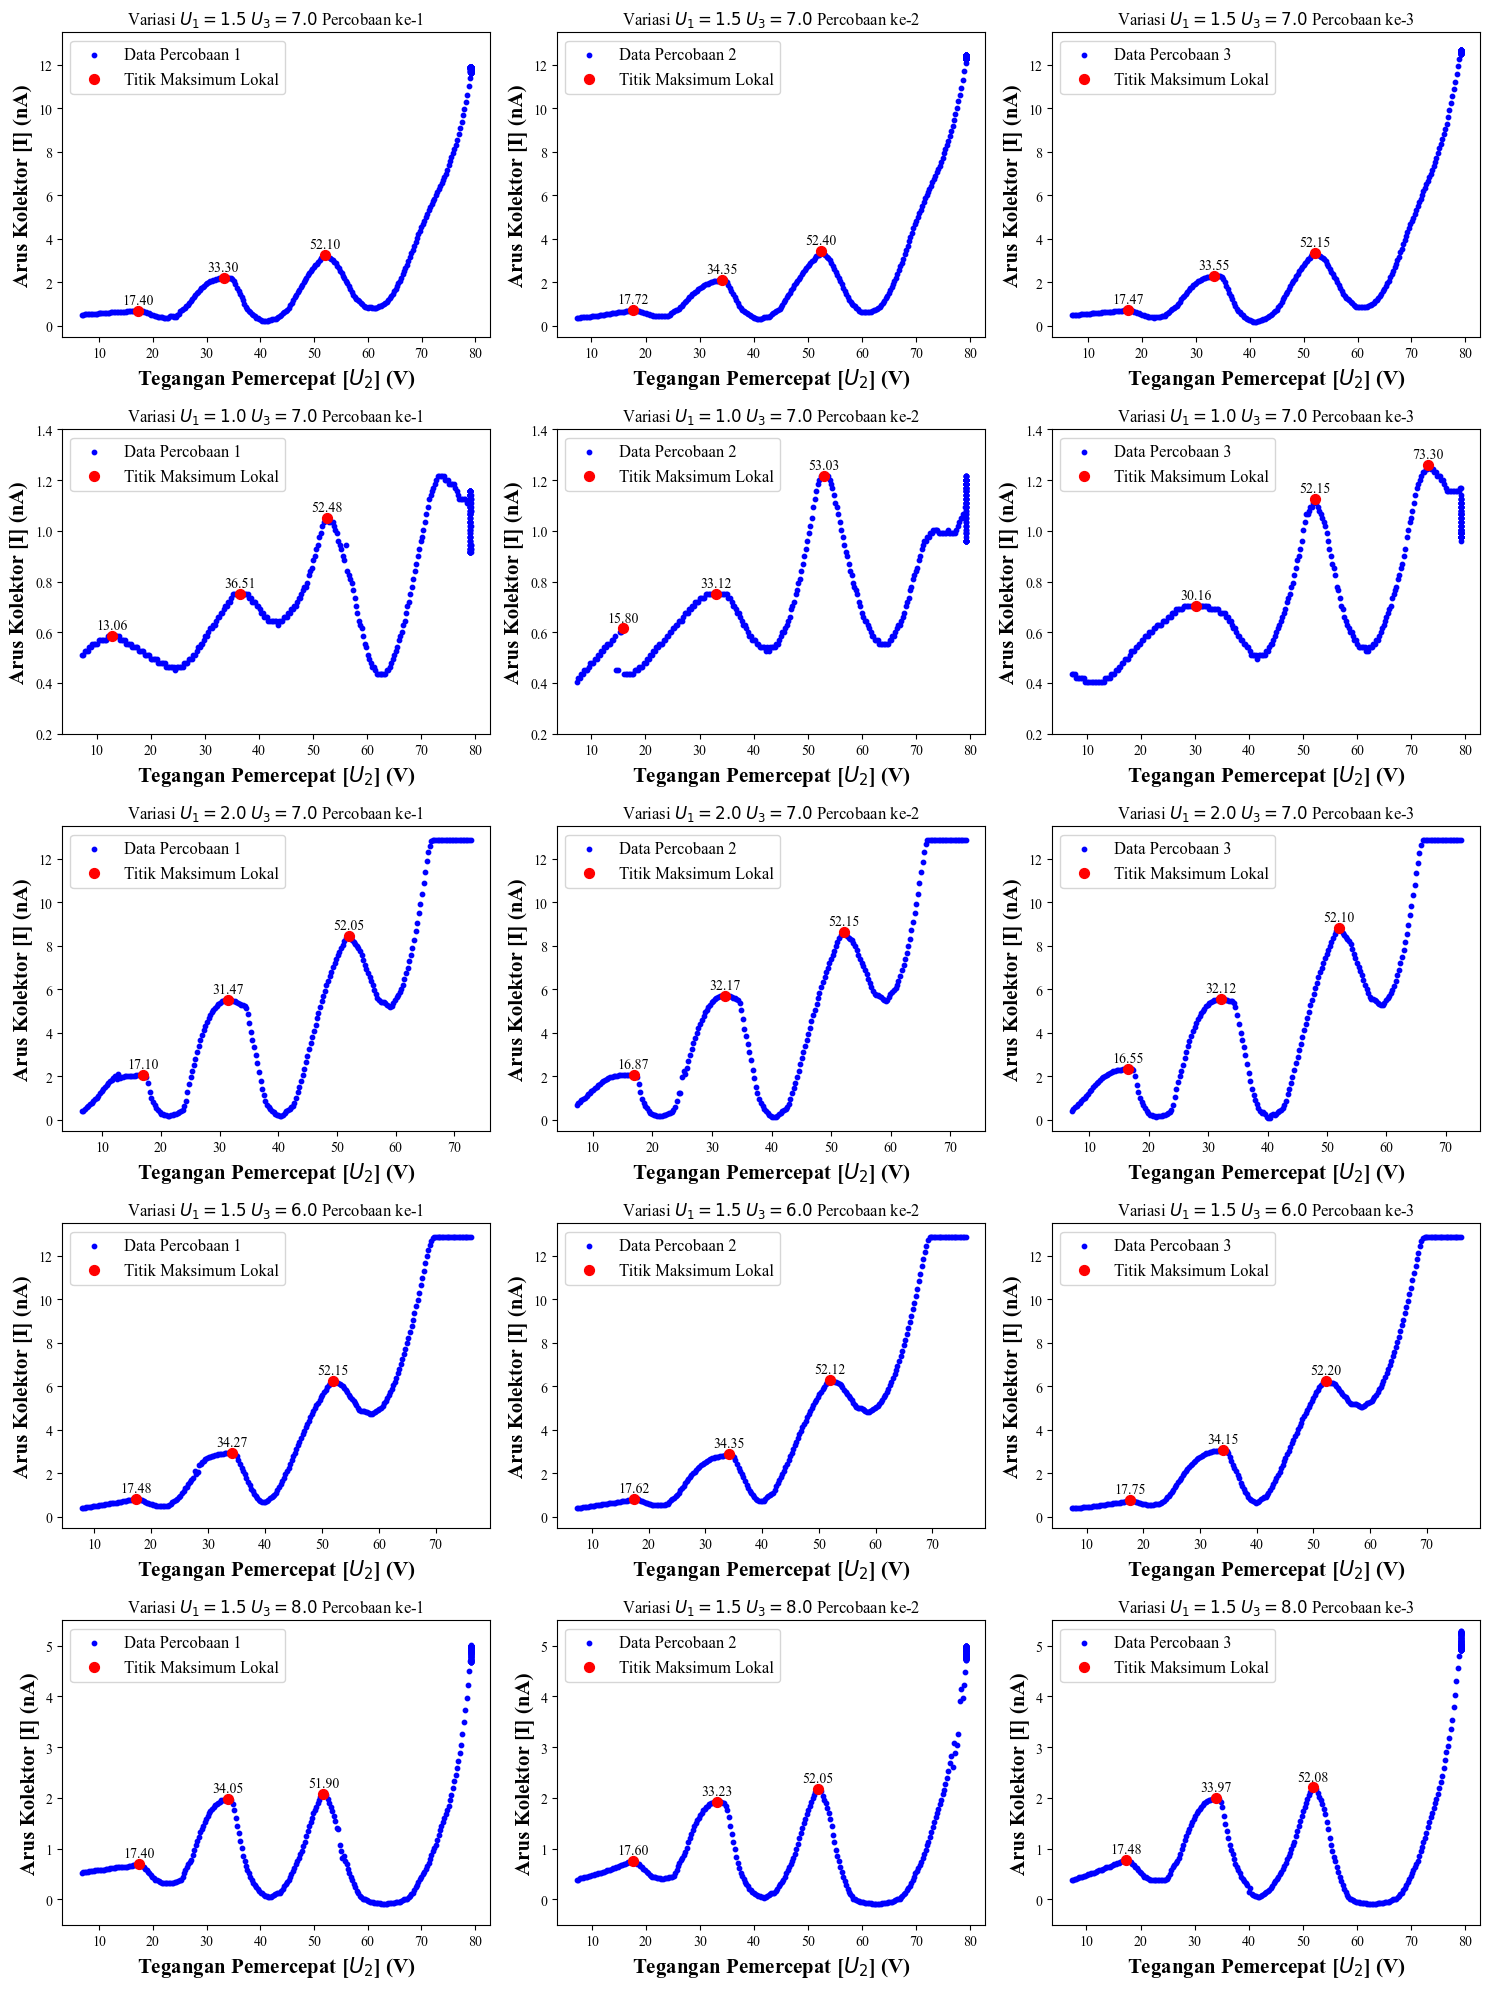

In [21]:
# gambaran semuanya

# Set up a figure with subplots
num_sheets = len(csv_files)  # Adjusts based on the actual number of sheets
n=0

# Set the font to Times New Roman
mpl.rcParams['font.family'] = 'Times New Roman'

# Set up a figure with 5x3 subplots
fig, axes = plt.subplots(5, 3, figsize=(15, 20))  # Adjust size as needed
axes = axes.flatten()  # Flatten to simplify indexing

# matrix to store the peaks' U3
x_peak = [[[0 for _ in range(3)] for _ in range(3)] for _ in range(5)]

# Loop through each csv
for i, csv_file in enumerate(csv_files[:15]):  
    n+=1 # grafik ke berapa
    variasi_ke = (n-1) // 3 + 1
    percobaan_ke = n % 3
    if(percobaan_ke == 0):
        percobaan_ke +=3

    # Load data from the current csv
    file_path = os.path.join(folder_path, csv_file)
    data = pd.read_csv(file_path, sep=separator)
    
    # 'x' and 'y' columns in each csv
    x = data['Acceleration voltage U_B / V']
    y = data['Collector current I_A / nA']
    
    # Find local peaks in the y data
    peaks0, _ = find_peaks(y, distance=30)
    if(n==7): # fine tune graph ke7
        x_numpy = np.array(x)
        lowest_index = np.where(x_numpy > 13)[0][0]
        y_dummy = y.copy()
        y_dummy[:lowest_index] = [0 for i in range(lowest_index)]
        peaks0, _ = find_peaks(y_dummy, distance=30)

    # remove x lower than 10V, higher than 77V
    peaks1 = np.array(peaks0)
    peaks = peaks1[(x[peaks1] >= 10) & (x[peaks1] <= 77)]
    peaks2 = peaks.copy()
    ref = y[peaks[0]]
    for j in peaks:
        if(y[j]<ref):
            peaks2 = remove_value(peaks,j)
        else:
            ref= y[j]
    peaks = peaks2

    # Plot on the corresponding subplot
    ax = axes[i]
    # Scatter plot for the current csv
    ax.scatter(x, y, color='blue', s=10, label=('Data Percobaan '+str(percobaan_ke)))
    ax.scatter(x[peaks[:3]], y[peaks[:3]], color='red', s=50, label='Titik Maksimum Lokal')
    
    # Annotate each peak with its x-coordinate
    peak_count = 0
    for peak in peaks[:3]:
        x_peak[variasi_ke - 1][percobaan_ke - 1][peak_count] = avg_peak(x, y, peak)
        ax.annotate(f"{x_peak[variasi_ke - 1][percobaan_ke - 1][peak_count]:.2f}", (x[peak], y[peak]), textcoords="offset points", xytext=(0,5), ha='center')
        peak_count += 1

    
    # Set titles and labels for each subplot
    ax.set_xlabel('Tegangan Pemercepat [$U_{2}$] (V)', fontsize=15, fontweight='bold')
    ax.set_ylabel('Arus Kolektor [I] (nA)', fontsize=15, fontweight='bold')
    ax.legend(fontsize=12, loc='upper left')
    ax.set_title(f'Variasi $U_{1}={csv_file[0:3]}$ $U_{3}={csv_file[4:7]}$ Percobaan ke-{csv_file[8]}')
    adjust_ylim(variasi_ke, (-0.5,13.5), (0.2, 1.4), (-0.5, 13.5), (-0.5, 13.5), (-0.5, 5.5), ax)

    # Save the figure with high resolution
    # plt.savefig(f'figs/var{variasi_ke}/{csv_file}.png', dpi=300, bbox_inches='tight')  # Adjust dpi as needed

plt.tight_layout()
plt.show()

In [22]:
print(x_peak)

[[[17.4, 33.3, 52.1], [17.716666666666665, 34.35, 52.4], [17.466666666666665, 33.55, 52.15]], [[13.0625, 36.513636363636365, 52.48333333333333], [15.8, 33.11666666666666, 53.03333333333333], [30.164705882352944, 52.15, 73.30000000000001]], [[17.1, 31.46666666666667, 52.05], [16.866666666666667, 32.166666666666664, 52.15], [16.55, 32.11666666666667, 52.1]], [[17.475, 34.266666666666666, 52.15], [17.625, 34.35, 52.125], [17.75, 34.15, 52.2]], [[17.4, 34.05, 51.9], [17.6, 33.233333333333334, 52.05], [17.475, 33.96666666666667, 52.075]]]


In [23]:
# matrix substractor
def mat3_subs(A, index1, index2):
    C = []
    for i in range(len(A)):
        C.append([])
        for j in range(len(A[0])):
            C[i].append(A[i][j][index1] - A[i][j][index2])
    return C

def mat3_avg(A,  index1, index2):
    C = []
    for i in range(len(A)):
        C.append([])
        for j in range(len(A[0])):
            C[i].append((A[i][j][index1] + A[i][j][index2])/2) 
    return C
            

# hitung selisih peak bersebelahan
DeltaU = x_peak.copy()
DeltaU[:][:][0] = mat3_subs(x_peak, 1, 0)
DeltaU[:][:][1] = mat3_subs(x_peak,2,1)
DeltaU = mat3_avg(DeltaU, 0, 1)

# Convert to Pandas DataFrame
DeltaU_df = pd.DataFrame(DeltaU, columns=['Percobaan 1', 'Percobaan 2', 'Percobaan 3'])
# Transpose the DataFrame
DeltaU_tabel = DeltaU_df.T

# Calculate the mean for each column
average_row = DeltaU_df.mean(axis=1)

# Append the row for 'rata-rata' to the transposed DataFrame
DeltaU_tabel.loc['Rata-rata'] = average_row


# Print the transposed DataFrame
print("ΔU variasi 0 hingga 4 Percobaan 1 hingga 3:")
print(DeltaU_tabel)

ΔU variasi 0 hingga 4 Percobaan 1 hingga 3:
                     0          1          2          3          4
Percobaan 1  25.350000  24.788068  24.283333  25.870833  25.725000
Percobaan 2  26.033333  24.458333  24.516667  25.987500  25.416667
Percobaan 3  25.508333  41.157353  24.333333  25.950000  25.720833
Rata-rata    25.630556  30.134585  24.377778  25.936111  25.620833


In [24]:
# dengan variasi 0: 1.5 7.0, 1: 1.0 7.0, 2: 2.0 7.0, 3: 1.5 6.0, 4: 1.5 8.0

In [25]:
#heatmap

[17.35, 19.710416666666664, 17.474999999999998, 17.3375, 17.25]


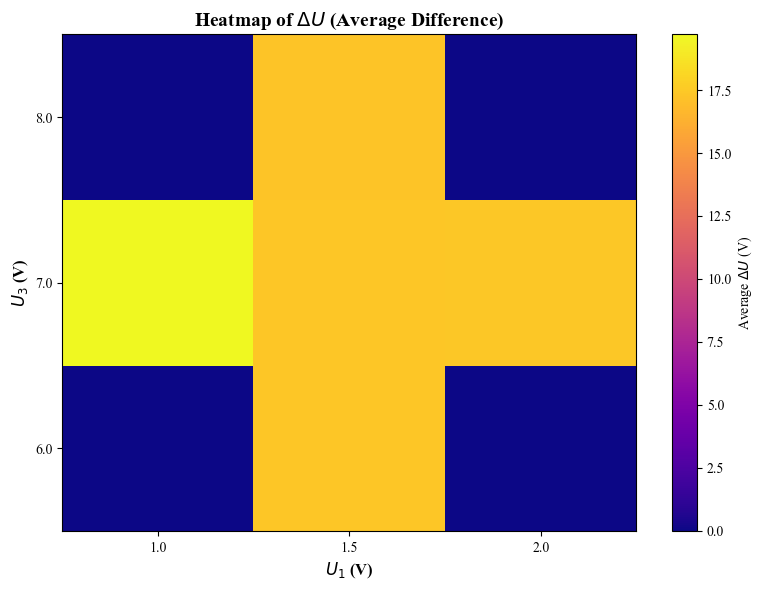

In [26]:
# untuk percobaan 1

# Variasi U1 dan U3
U1_variations = [1.5, 1.0, 2.0, 1.5, 1.5]  # Variasi U1
U3_variations = [7.0, 7.0, 7.0, 6.0, 8.0]  # Variasi U3

# Ambil daftar unik U1 dan U3
unique_U1 = sorted(list(set(U1_variations)))
unique_U3 = sorted(list(set(U3_variations)))

x_peak_data = [
    x_peak[variasi][0][:3] for variasi in range(len(x_peak))
]

# Function to compute delta U (average of differences between peaks)
def calculate_delta_u(peaks):
    if len(peaks) < 2:
        return 0  # No delta possible if fewer than 2 peaks
    differences = [abs(peaks[i + 1] - peaks[i]) for i in range(len(peaks) - 1)]
    return np.mean(differences)

# Compute delta U for each variation
delta_u_values = [calculate_delta_u(peaks) for peaks in x_peak_data]
# Map these delta U values to the heatmap structure
heatmap_data = np.zeros((len(unique_U3), len(unique_U1)))

for i, (u1, u3, delta) in enumerate(zip(U1_variations, U3_variations, delta_u_values)):
    u1_index = unique_U1.index(u1)
    u3_index = unique_U3.index(u3)
    heatmap_data[u3_index, u1_index] = delta

# Plot the updated heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap="plasma", origin="lower", aspect="auto")

# Add labels and title
plt.xticks(ticks=np.arange(len(unique_U1)), labels=unique_U1)
plt.yticks(ticks=np.arange(len(unique_U3)), labels=unique_U3)
plt.xlabel("$U_1$ (V)", fontsize=12, fontweight='bold')
plt.ylabel("$U_3$ (V)", fontsize=12, fontweight='bold')
plt.title("Heatmap of $\Delta U$ (Average Difference)", fontsize=14, fontweight='bold')
plt.colorbar(label="Average $\Delta U$ (V)")

plt.tight_layout()
plt.show()

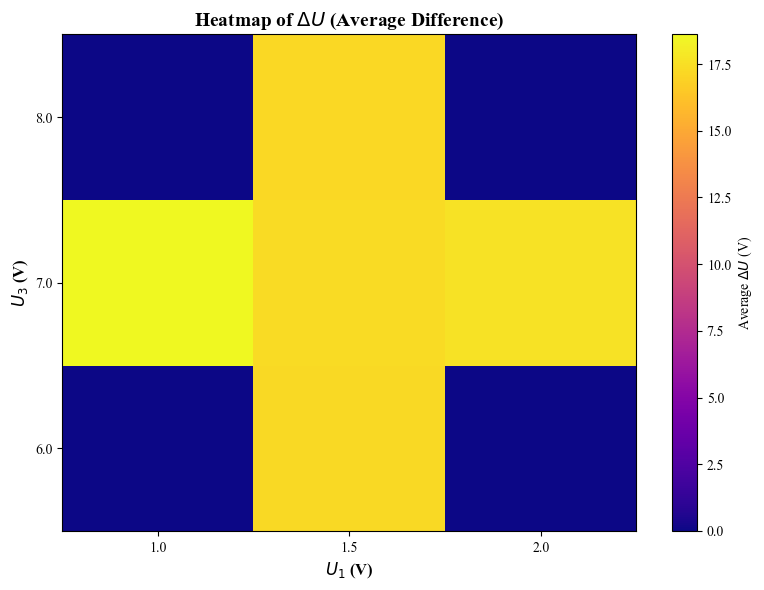

In [30]:
# untuk percobaan 2

# Variasi U1 dan U3
U1_variations = [1.5, 1.0, 2.0, 1.5, 1.5]  # Variasi U1
U3_variations = [7.0, 7.0, 7.0, 6.0, 8.0]  # Variasi U3

# Ambil daftar unik U1 dan U3
unique_U1 = sorted(list(set(U1_variations)))
unique_U3 = sorted(list(set(U3_variations)))

x_peak_data = [
    x_peak[variasi][1][:3] for variasi in range(len(x_peak))
]

# Function to compute delta U (average of differences between peaks)
def calculate_delta_u(peaks):
    if len(peaks) < 2:
        return 0  # No delta possible if fewer than 2 peaks
    differences = [abs(peaks[i + 1] - peaks[i]) for i in range(len(peaks) - 1)]
    return np.mean(differences)

# Compute delta U for each variation
delta_u_values = [calculate_delta_u(peaks) for peaks in x_peak_data]
# Map these delta U values to the heatmap structure
heatmap_data = np.zeros((len(unique_U3), len(unique_U1)))

for i, (u1, u3, delta) in enumerate(zip(U1_variations, U3_variations, delta_u_values)):
    u1_index = unique_U1.index(u1)
    u3_index = unique_U3.index(u3)
    heatmap_data[u3_index, u1_index] = delta

# Plot the updated heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap="plasma", origin="lower", aspect="auto")

# Add labels and title
plt.xticks(ticks=np.arange(len(unique_U1)), labels=unique_U1)
plt.yticks(ticks=np.arange(len(unique_U3)), labels=unique_U3)
plt.xlabel("$U_1$ (V)", fontsize=12, fontweight='bold')
plt.ylabel("$U_3$ (V)", fontsize=12, fontweight='bold')
plt.title("Heatmap of $\Delta U$ (Average Difference)", fontsize=14, fontweight='bold')
plt.colorbar(label="Average $\Delta U$ (V)")

plt.tight_layout()
plt.show()

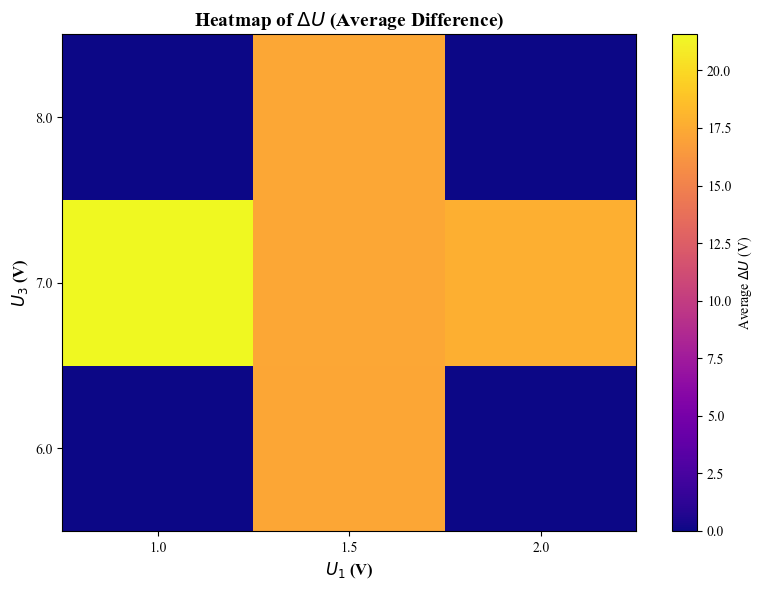

In [28]:
# untuk percobaan 3

# Variasi U1 dan U3
U1_variations = [1.5, 1.0, 2.0, 1.5, 1.5]  # Variasi U1
U3_variations = [7.0, 7.0, 7.0, 6.0, 8.0]  # Variasi U3

# Ambil daftar unik U1 dan U3
unique_U1 = sorted(list(set(U1_variations)))
unique_U3 = sorted(list(set(U3_variations)))

x_peak_data = [
    x_peak[variasi][2][:3] for variasi in range(len(x_peak))
]

# Function to compute delta U (average of differences between peaks)
def calculate_delta_u(peaks):
    if len(peaks) < 2:
        return 0  # No delta possible if fewer than 2 peaks
    differences = [abs(peaks[i + 1] - peaks[i]) for i in range(len(peaks) - 1)]
    return np.mean(differences)

# Compute delta U for each variation
delta_u_values = [calculate_delta_u(peaks) for peaks in x_peak_data]

# Map these delta U values to the heatmap structure
heatmap_data = np.zeros((len(unique_U3), len(unique_U1)))

for i, (u1, u3, delta) in enumerate(zip(U1_variations, U3_variations, delta_u_values)):
    u1_index = unique_U1.index(u1)
    u3_index = unique_U3.index(u3)
    heatmap_data[u3_index, u1_index] = delta

# Plot the updated heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap="plasma", origin="lower", aspect="auto")

# Add labels and title
plt.xticks(ticks=np.arange(len(unique_U1)), labels=unique_U1)
plt.yticks(ticks=np.arange(len(unique_U3)), labels=unique_U3)
plt.xlabel("$U_1$ (V)", fontsize=12, fontweight='bold')
plt.ylabel("$U_3$ (V)", fontsize=12, fontweight='bold')
plt.title("Heatmap of $\Delta U$ (Average Difference)", fontsize=14, fontweight='bold')
plt.colorbar(label="Average $\Delta U$ (V)")

plt.tight_layout()
plt.show()